### This notebook reproduces the urban accessibility map for Munich, from this tutorial:
https://towardsdatascience.com/measuring-pedestrian-accessibility-97900f9e4d56


## Steps
* Step 1: get the POIs for Munich, including GPS coordinates  
* Step 2: create Pandana network   
* Step 3: assign POIs, compute shortest distances
* Step 4: plot the shortest distances on the accesibility heatmap  


In [1]:
# libraries needed
import pandas as pd
import numpy as np
import datetime as dt
import time
import os

import pandana as pdna
import geopandas as gpd
import osmnx as ox

from shapely.geometry.polygon import Polygon
from shapely.geometry import box

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# to display plot in the notebook
%matplotlib inline


## Step 1: get the POIs for Munich

Get network map and POIs from the network

Use the documentation from here:
https://osmnx.readthedocs.io/en/stable/osmnx.html


In [14]:
# get a GeoDataFrame from Munich
place = ox.gdf_from_place('Munich, Germany')
bounds_city = place['geometry'][0].bounds
print(bounds_city)
# order bounds: 'east','north','south','west'
polygon_city = Polygon((list(box(bounds_city[0],bounds_city[1],bounds_city[2],bounds_city[3]).exterior.coords)))

(11.360777, 48.0616244, 11.7229083, 48.2481162)


In [11]:
# set POIs of interest
amenity = 'hospital'#['hospital','cafe','school','pharmacy']#'restaurant','clinic','bank','park',

In [14]:
# get POIs from Polygon
pois = ox.pois.pois_from_polygon(polygon_city, [amenity])

print('Number of POIs')
print(len(pois))
print(pois[['amenity','name']].head())
# a long list of all the info about the POIs: (maybe useful in the future)
# print(list(pois.columns))

Number of POIs
157
           amenity                                         name
60234799  hospital                          Medizinische Klinik
60235532  hospital            Mund-, Kiefer-, Gesichtschirurgie
60235905  hospital             Dr. von Haunersches Kinderspital
60237053  hospital           Poliklinik Zahnärztliche Prothetik
60237068  hospital  Poliklinik Zahnerhaltung und Parodontologie


In [ ]:
'''
# If we want to plot the network:
# city graph
G = ox.graph_from_address('Munich, Germany')
ox.plot_graph(G)
'''

In [29]:

'''
# IF we want to plot the POIs on the map:
import matplotlib.pyplot as plt
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'Europe'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
pois.plot(ax=ax, color='red')
plt.show()
'''

"\n# IF we want to plot the POIs on the map:\nimport matplotlib.pyplot as plt\nworld = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))\n\n# We restrict to South America.\nax = world[world.continent == 'Europe'].plot(\n    color='white', edgecolor='black')\n\n# We can now plot our ``GeoDataFrame``.\npois.plot(ax=ax, color='red')\nplt.show()\n"

Now we need to transform the addresses in GPS coordinates, because they are not available in the POIs data frame

### First test geocoding works with Nominatim (number of requests is limited)
If the next cell fails, a geocoding alternative to extract the coordinates from POI names may be needed.
A list of alternatives is here: https://wiki.openstreetmap.org/wiki/Search_engines  
Failed attempts (adddresses not recognized): 
* use Nominatim rate_limiter.RateLimiter to introduce delays and retries 
* geocoder Python: https://geocoder.readthedocs.io/  
* overpass API: https://wiki.openstreetmap.org/wiki/Overpass_API/Python_Wrapper  
Code not working on POI addersses   
import overpass  
api = overpass.API()  
response = api.get('node["name"="6 Gartenstadtstraße München DE"]')  
response['features'][0]['geometry']['coordinates'][0]  
  
Working but need to call from Python:  
* http://photon.komoot.de/  
* https://www.ideeslibres.org/GeoCheck/  

In [15]:
# basic test we can encode a location by address:
geolocator = Nominatim(user_agent="y")
location = geolocator.geocode("6 Gartenstadtstraße München DE")
print((location.latitude, location.longitude))

(48.1169479, 11.6702206)


In [16]:
t1 = time.time()

pois['complete address'] = pois['addr:housenumber'] + ' ' + pois['addr:street'] + ' ' + pois['addr:city'] + ' ' + pois['addr:country']

# this takes long for all POIs (several minutes or more) (alternatively take less POIS
# limited to first 100 points for now
pois_test = pois.reset_index().copy()
def fct(x):
    try:
        location = geolocator.geocode(x)
    except:
        return np.nan
    return location
t2 = time.time()
pois_test['loc'] = pois_test['complete address'].apply(lambda x: fct(x))
print('time geocoding')
print(t2-t1)
pois_test = pois_test.dropna(subset=['loc']).reset_index()
# extract coordinates
pois_test['lat'] = pois_test['loc'].apply(lambda x:x.latitude)
pois_test['lon'] = pois_test['loc'].apply(lambda x:x.longitude)
pois_test.loc[pois_test['complete address'].isnull(),'lat'] = np.NaN
pois_test.loc[pois_test['complete address'].isnull(),'lon'] = np.NaN
pois_test = pois_test[['name','lat','lon','complete address']].dropna()
print(pois_test.head())

# always cache geocoded addresses because there a limit per day: 
if not os.path.exists('pois_coord'):
    os.makedirs('pois_coord')
pois_test.to_pickle('pois_coord/' + amenity + '_' + str(dt.datetime.now()).replace(':','').replace(' ','-').replace('.','-') + '.pkl')

time geocoding
0.058594703674316406
                                          name        lat        lon  \
0                          Medizinische Klinik  48.132249  11.561818   
1            Mund-, Kiefer-, Gesichtschirurgie  48.131001  11.560525   
2             Dr. von Haunersches Kinderspital  48.130282  11.559205   
3           Poliklinik Zahnärztliche Prothetik  48.131329  11.558192   
4  Poliklinik Zahnerhaltung und Parodontologie  48.131329  11.558192   

               complete address  
0   1 Ziemssenstraße München DE  
1  2a Lindwurmstraße München DE  
2   4 Lindwurmstraße München DE  
3    70 Goethestraße München DE  
4    70 Goethestraße München DE  


In [17]:
# check coordinates fine:
pois_test.head()

,name,lat,lon,complete address
0,Medizinische Klinik,48.132249,11.561818,1 Ziemssenstraße München DE
1,"Mund-, Kiefer-, Gesichtschirurgie",48.131001,11.560525,2a Lindwurmstraße München DE
2,Dr. von Haunersches Kinderspital,48.130282,11.559205,4 Lindwurmstraße München DE
3,Poliklinik Zahnärztliche Prothetik,48.131329,11.558192,70 Goethestraße München DE
4,Poliklinik Zahnerhaltung und Parodontologie,48.131329,11.558192,70 Goethestraße München DE


Keep the POIs for later, next create the Pandana network we want to compute the shortest paths on

## Step 2: create Pandana network, assign POIs, compute shortest distances

Create Pandana network, precomute, initiatilize, set POIs and calculate nearest POIs as in the tutorial:
https://udst.github.io/pandana/tutorial.html

First need to transform the nodes and edges from the shapefile to match the Pandana format: 
* extract x,y columns for coordinates
* extract weight column of edges
* make the nodes index int, from the osmid, by reseting the index of nodes and merging


### only run the next cell if no shape file already available

In [50]:
# reorder the bounds_city to match the funciton description: 
# from longitude min, latitude min, longitude max, latitude max to
# north, south, east, west

# this takes long! several minutes or longer
G = ox.graph_from_bbox(bounds_city[3], bounds_city[1], bounds_city[2], bounds_city[0], network_type='walk')
# get road network and save as .shp
ox.save_graph_shapefile(G, filename='sample', folder='data', encoding='utf-8')

KeyboardInterrupt: 

### from here on run cells normally

In [2]:
nodes = gpd.read_file('data/sample/nodes/nodes.shp')
edges = gpd.read_file('data/sample/edges/edges.shp')

In [3]:
nodes['x'] = nodes['geometry'].apply(lambda x:x.coords[0][0])
nodes['y'] = nodes['geometry'].apply(lambda x:x.coords[0][1])
edges['weight'] = edges['length'].astype(float)
nodes['x'] = nodes['x'].astype(float)
nodes['y'] = nodes['y'].astype(float)

In [4]:
nodes['ix']=nodes.index
test  = pd.merge(nodes[['osmid','ix']].rename(columns={'osmid':'from','ix':'from_ix'}),edges,on='from')
test  = pd.merge(nodes[['osmid','ix']].rename(columns={'osmid':'to','ix':'to_ix'}),test,on='to')

In [6]:
nodes.head()

,highway,osmid,ref,geometry,x,y,ix
0,None,1909719042,None,POINT (11.6278848 48.2470903),11.627885,48.247090,0
1,None,1909719044,None,POINT (11.6266001 48.2472798),11.626600,48.247280,1
2,turning_circle,307757062,None,POINT (11.5525641 48.1912629),11.552564,48.191263,2
3,None,307757067,None,POINT (11.5539391 48.1918998),11.553939,48.191900,3
4,None,307757071,None,POINT (11.5534609 48.1917883),11.553461,48.191788,4


In [5]:
net=pdna.Network(nodes["x"], nodes["y"], test["from_ix"], test["to_ix"],
                 test[["weight"]])

c:\users\mraf\anaconda3\envs\tensorflow\lib\site-packages\pandana\network.py:132: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.as_matrix().astype('float32'),
c:\users\mraf\anaconda3\envs\tensorflow\lib\site-packages\pandana\network.py:133: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix().astype('int32'),
c:\users\mraf\anaconda3\envs\tensorflow\lib\site-packages\pandana\network.py:134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges_df[edge_weights.columns].transpose()


In [6]:
# check number of nodes in the network
net.node_ids

RangeIndex(start=0, stop=145731, step=1)

In [7]:
print('this takes also some minutes')
net.precompute(3000)

this takes also some minutes


## Step 3: calculate shortest distances to POIs 
(continue tutorial from here: https://udst.github.io/pandana/tutorial.html)


In [8]:
net.init_pois(2,10000,10)

In [12]:
# if not already existing load it from cached data
pois_test = pd.read_pickle('pois_coord/hospital_2020-01-30-123302-273052.pkl')
print(len(pois_test))
# set pois coordinates
net.set_pois(amenity, pois_test['lon'], pois_test['lat'])

33


## Step 4: plot the shortest distances as accesibility heatmap

## Still need to debug!

accessiblity df are the distances from POIs to nearest restaurant

need to check why they are mostly = max distance (2000m)

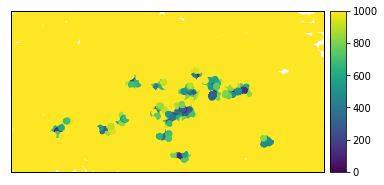

In [15]:
amenity = 'hospital'

def plot_nearest_amenity(network,amenity,n, distance, num_pois, bbox):
    accessibility = network.nearest_pois(distance=distance, category=amenity, num_pois=num_pois)
    
    # important to rearrange the coordinates: 
    network.plot(accessibility[n], [bounds_city[1],bounds_city[0],bounds_city[3],bounds_city[2]])
    #ax.set_facecolor('k')
    #ax.set_title('Pedestrian accessibility in Casablanca (Walking distance to {}, meters (n = {}))'.format(amenity,n), fontsize=14);

plot_nearest_amenity(net,amenity,1, distance=1000, num_pois=3, bbox = bounds_city)

### Extensions
* compare walking distance to 1st vs 5th nearest POI -> the 5th nearest POI is a better measure of walkability
* define and calculate a metric which weights more POI types (school, clinic, restaurant) (as suggested in the article)
* extend as in the tutorial to plot time to travel using public transport, road or waling - unclear how this is done exactly: "let’s build a grid of 250 square meter cells behind our road network, attach each cell to its closest node, and translate the distances into walk, drive or public transit time.")
* extensions from tutorial:
    * "Good quality, locally produced GIS data can be used instead of OSM (and indeed is preferable)."
    * "An important extension: this method is a great input for property price modelling or building-level predictive models. Hedonic price models assume that, for example, home buyers pay more for a home where they can easily walk to a Starbucks or drive to a hospital. Snapping tax lot boundaries (or OSM building footprints) to the network, the same way as we just attached grid squares to it, allows us to derive this data for any given property."
    * "Likewise, machine learning models to predict crime or fire risk require as many attributes as possible to characterize each building’s place in the urban fabric. Rapid network-constrained queries through this kind of framework can answer many questions "